In [ ]:
!pip3 uninstall torch torchvision --yes

In [ ]:
!pip3 install torch==1.11.0 torchvision==0.12

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

import time
import os
import copy
import random

cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102


In [2]:
train = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')

In [3]:
y_train = train['label']
X_train = train.drop('label', axis=1)

In [4]:
X_train /= 255.
test /= 255.

In [5]:
X_train.shape

(42000, 784)

In [6]:
y_train.shape

(42000,)

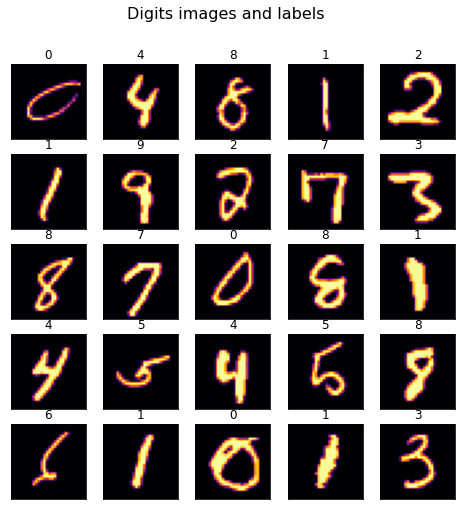

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Digits images and labels', fontsize=16)
ax = ax.ravel()
for i in range(25):
    sample_n = random.randint(0, X_train.shape[0])
    ax[i].imshow(np.array(X_train.iloc[sample_n]).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(y_train[sample_n], fontsize = 12)

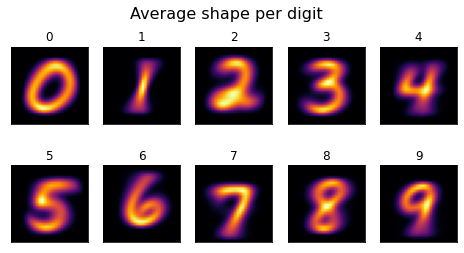

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Average shape per digit', fontsize=16)

ax = ax.ravel()

for i in range(10):
    ax[i].imshow(np.array(train[train['label'] == i].drop('label', axis=1).mean()).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(i, fontsize = 12)

In [9]:
X_train_array = np.array(X_train)
X_train_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
test_array = np.array(test)
test_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
X_train_array = X_train_array.reshape(42000, 1, 28, 28)
test_array = test_array.reshape(-1, 1, 28, 28)

In [12]:
train_data = []
for i in range(len(X_train_array)):
   train_data.append([X_train_array[i], y_train[i]])
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=4,
                                             shuffle=True, num_workers=4)
              ,'test':  torch.utils.data.DataLoader(test_array, batch_size=4,
                                             shuffle=False, num_workers=4)}

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
training_loader = dataloaders['train']
dataiter = iter(training_loader)
images, labels = dataiter.next()

In [14]:
images.shape

torch.Size([4, 1, 28, 28])

In [43]:
images = images.float()

In [44]:
images


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
    

In [15]:
labels.shape

torch.Size([4])

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [50]:
model_ft = models.regnet_x_8gf(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft.stem[0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)